In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

# Q1

### Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Selected device:', device)

Selected device: cuda


### Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.


### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

### Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q1.a

In [ ]:
# Original
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output, true_label)

def discriminator_loss(output, true_label):
    return criterion(output, true_label)

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        # Training Discriminator
        for _ in range(k):
            optim_d.zero_grad()

            # Real data
            real_data = data[0].to(device)
            real_output = discriminator(real_data)
            loss_real = criterion(real_output, label_real(real_data.size(0)))

            # Fake data
            fake_data = generator(create_noise(batch_size, nz)).detach()
            fake_output = discriminator(fake_data)
            loss_fake = criterion(fake_output, label_fake(fake_data.size(0)))

            # Update the discriminator
            loss_d += loss_real.item() + loss_fake.item()
            (loss_real + loss_fake).backward()
            optim_d.step()

        # Training Generator
        optim_g.zero_grad()
        generated_data = generator(create_noise(batch_size, nz))
        output = discriminator(generated_data)
        loss_fake_g = criterion(output, label_real(batch_size))
        loss_g += loss_fake_g.item()
        
        # Update the generator
        loss_fake_g.backward()
        optim_g.step()

    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}a.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi  # total generator loss for the epoch
    epoch_loss_d = loss_d / bi  # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
print(losses_g)
print(losses_d)

In [ ]:
# plot and save the generator and discriminator loss
losses_g = [1.496245300413197, 3.261621749108164, 7.022783597310384, 3.3063426879990816, 1.515804510595452, 2.603245025771296, 1.3519370347006707, 2.014565797952505, 1.9564650237050831, 1.9159216959761758, 2.036492809271201, 2.9470508190301747, 2.376826509451255, 3.044224071706462, 2.6508977148267956, 3.4419784403254843, 3.751982713356996, 3.4356087904710035, 3.559653763078217, 3.7466007460895767, 3.9472769274670854, 3.432777189800882, 3.9055899188049836, 3.9195069696149254, 3.9520978030995426, 4.014600295286912, 3.39073624366369, 3.6184005268618593, 3.4083999038761497, 4.069045005700527, 4.155531345269619, 3.28077056672838, 3.4707041499961138, 3.6264773291400356, 3.591104020420303, 3.5389136697492027, 3.4212685018523126, 3.707501228039081, 3.7960486432425995, 3.6245148670979037, 3.5763060211116433, 3.5544503448355913, 3.5342596005170774, 3.6616230540805392, 3.4724208615783954, 3.512666529060429, 3.589617509108323, 3.486772834745228, 3.4094247756860194, 3.298320764150375, 3.1405255896413427, 3.3654625599200907, 3.153508838425335, 3.0367809218219204, 3.033514323397579, 3.0932667785220676, 3.1881213575346856, 2.9369430562369843, 2.9490307335160737, 2.741137586088262, 2.727037971855229, 2.6992686059739857, 2.6795386269561248, 2.819159465977269, 2.855470749048086, 2.7736360150524693, 2.643596620641203, 2.6036511639244537, 2.660570559338627, 2.6188242394700008, 2.5472087564631405, 2.545558664533827, 2.528051110414358, 2.387256567294781, 2.4244218728481193, 2.466096944279141, 2.400223146137009, 2.2989602251949472, 2.2583610002811136, 2.2751030646837673, 2.305335805966304, 2.214424633572244, 2.1675302472888913, 2.2574961562441964, 2.26887953790844, 2.2955225471757417, 2.338691074624021, 2.2106978689503465, 2.2242658820926633, 2.227968791611174, 2.30641303001306, 2.1081272954614754, 2.089700426810827, 2.1139166518154306, 2.0484760683825893, 2.151492837147835, 2.015869380062462, 1.9882421534285586, 1.9941664068107932, 1.999451994895935]
losses_d = [0.8893410560125724, 1.1574308508768296, 0.2765143827861573, 0.8711623911483165, 1.111733322469597, 0.7029393541141071, 1.1434719398235664, 0.7409815307483714, 1.0401742668488088, 1.111813304452305, 0.6894641979637309, 0.5753189399520047, 0.5430745894455502, 0.5828520193313941, 0.5257816194978535, 0.510820164066604, 0.49723917978186893, 0.4263858256431726, 0.4105561310982602, 0.3970351475808356, 0.5089376033880771, 0.48106055069937664, 0.36519060949357146, 0.3352527898282577, 0.46685545012736934, 0.3539909727744058, 0.4828302694691552, 0.47399358581910783, 0.41839436107339, 0.34427493504988843, 0.36504697353921384, 0.49695141702635676, 0.4350180121568533, 0.3948017787665893, 0.45274899893591547, 0.4148479915327496, 0.44616502809983033, 0.4067604280053041, 0.3361697267645445, 0.40795911581088334, 0.3673901824742301, 0.43238695156879914, 0.4225999706576013, 0.3690406766075354, 0.3697440441793356, 0.3851746558569945, 0.3812676987841598, 0.4051808881071898, 0.4135146111759365, 0.40972002105325717, 0.4427607933170775, 0.4268607842998627, 0.4580069143547971, 0.5010944458409252, 0.4756701168978316, 0.45712277891798914, 0.46961235840860593, 0.521237252232356, 0.5098741373572594, 0.5203256766256105, 0.5154793532485635, 0.5261298747908356, 0.5350182954317484, 0.5253699508487669, 0.5574721430993488, 0.5514898188093789, 0.5597681139524167, 0.563242620891995, 0.5634650349871725, 0.5743208221900158, 0.5802628892099756, 0.5739114192815927, 0.594280592396728, 0.6885134412182702, 0.6788296572163574, 0.6418657081249433, 0.644245468143724, 0.6700845052543868, 0.659326995539869, 0.7020274168915219, 0.6779395673010085, 0.7021458955147327, 0.7137865183445123, 0.6996581044971434, 0.6892450886149691, 0.7063646340726787, 0.7089090396960577, 0.7031351237470268, 0.7202505726590116, 0.7109096396682609, 0.7118628906388568, 0.7261087959393476, 0.7454318206789147, 0.7285434050947173, 0.7534168737056928, 0.7580769489973019, 0.7909154809183545, 0.7641839230926628, 0.7821489455353501, 0.7750086076239235]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

# Q1.b

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Selected device:', device)
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [8]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output, true_label)

def discriminator_loss(output, true_label):
    return criterion(output, true_label)

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        # Training Discriminator
        for _ in range(k):
            optim_d.zero_grad()

            # Real data
            real_data = data[0].to(device)
            real_output = discriminator(real_data)
            loss_real = criterion(real_output, label_real(real_data.size(0)))

            # Fake data
            fake_data = generator(create_noise(batch_size, nz)).detach()
            fake_output = discriminator(fake_data)
            loss_fake = criterion(fake_output, label_fake(fake_data.size(0)))

            # Update the discriminator
            loss_d += loss_real.item() + loss_fake.item()
            (loss_real + loss_fake).backward()
            optim_d.step()

        # Training Generator
        optim_g.zero_grad()
        generated_data = generator(create_noise(batch_size, nz))
        output = discriminator(generated_data)
        loss_fake_g = criterion(output, label_fake(batch_size))
        loss_g += loss_fake_g.item()
        
        # Update the generator
        loss_fake_g.backward()
        optim_g.step()

    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}b.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi  # total generator loss for the epoch
    epoch_loss_d = loss_d / bi  # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
print(losses_g)
print(losses_d)

118it [00:09, 12.34it/s]                                                                                               


Epoch 1 of 100
Generator loss: 0.05826525, Discriminator loss: 0.08286744


118it [00:09, 12.83it/s]                                                                                               


Epoch 2 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.92it/s]                                                                                               


Epoch 3 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.33it/s]                                                                                               


Epoch 4 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.43it/s]                                                                                               


Epoch 5 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.57it/s]                                                                                               


Epoch 6 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.62it/s]                                                                                               


Epoch 7 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 8 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.66it/s]                                                                                               


Epoch 9 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.67it/s]                                                                                               


Epoch 10 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.50it/s]                                                                                               


Epoch 11 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 12 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.74it/s]                                                                                               


Epoch 13 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.76it/s]                                                                                               


Epoch 14 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.44it/s]                                                                                               


Epoch 15 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.77it/s]                                                                                               


Epoch 16 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.51it/s]                                                                                               


Epoch 17 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.90it/s]                                                                                               


Epoch 18 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 19 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.39it/s]                                                                                               


Epoch 20 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.74it/s]                                                                                               


Epoch 21 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.55it/s]                                                                                               


Epoch 22 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.92it/s]                                                                                               


Epoch 23 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.74it/s]                                                                                               


Epoch 24 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.71it/s]                                                                                               


Epoch 25 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 26 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.94it/s]                                                                                               


Epoch 27 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.90it/s]                                                                                               


Epoch 28 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.89it/s]                                                                                               


Epoch 29 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.97it/s]                                                                                               


Epoch 30 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.81it/s]                                                                                               


Epoch 31 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.98it/s]                                                                                               


Epoch 32 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.64it/s]                                                                                               


Epoch 33 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.82it/s]                                                                                               


Epoch 34 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 35 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.53it/s]                                                                                               


Epoch 36 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.60it/s]                                                                                               


Epoch 37 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.45it/s]                                                                                               


Epoch 38 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.63it/s]                                                                                               


Epoch 39 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.73it/s]                                                                                               


Epoch 40 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.57it/s]                                                                                               


Epoch 41 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.80it/s]                                                                                               


Epoch 42 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.83it/s]                                                                                               


Epoch 43 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.47it/s]                                                                                               


Epoch 44 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 45 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.73it/s]                                                                                               


Epoch 46 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.63it/s]                                                                                               


Epoch 47 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.94it/s]                                                                                               


Epoch 48 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 49 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.55it/s]                                                                                               


Epoch 50 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.67it/s]                                                                                               


Epoch 51 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.10it/s]                                                                                               


Epoch 52 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.39it/s]                                                                                               


Epoch 53 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.47it/s]                                                                                               


Epoch 54 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.39it/s]                                                                                               


Epoch 55 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.57it/s]                                                                                               


Epoch 56 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 57 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.74it/s]                                                                                               


Epoch 58 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.57it/s]                                                                                               


Epoch 59 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.85it/s]                                                                                               


Epoch 60 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.66it/s]                                                                                               


Epoch 61 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.31it/s]                                                                                               


Epoch 62 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.50it/s]                                                                                               


Epoch 63 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.72it/s]                                                                                               


Epoch 64 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.60it/s]                                                                                               


Epoch 65 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.60it/s]                                                                                               


Epoch 66 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.74it/s]                                                                                               


Epoch 67 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.66it/s]                                                                                               


Epoch 68 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.68it/s]                                                                                               


Epoch 69 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.59it/s]                                                                                               


Epoch 70 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.51it/s]                                                                                               


Epoch 71 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.59it/s]                                                                                               


Epoch 72 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.46it/s]                                                                                               


Epoch 73 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.59it/s]                                                                                               


Epoch 74 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 75 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.60it/s]                                                                                               


Epoch 76 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 77 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.62it/s]                                                                                               


Epoch 78 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.62it/s]                                                                                               


Epoch 79 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.71it/s]                                                                                               


Epoch 80 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.56it/s]                                                                                               


Epoch 81 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.39it/s]                                                                                               


Epoch 82 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.62it/s]                                                                                               


Epoch 83 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.71it/s]                                                                                               


Epoch 84 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.89it/s]                                                                                               


Epoch 85 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 86 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.58it/s]                                                                                               


Epoch 87 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.69it/s]                                                                                               


Epoch 88 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.54it/s]                                                                                               


Epoch 89 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.62it/s]                                                                                               


Epoch 90 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.77it/s]                                                                                               


Epoch 91 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.82it/s]                                                                                               


Epoch 92 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 93 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.52it/s]                                                                                               


Epoch 94 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.75it/s]                                                                                               


Epoch 95 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.34it/s]                                                                                               


Epoch 96 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.72it/s]                                                                                               


Epoch 97 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.48it/s]                                                                                               


Epoch 98 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.78it/s]                                                                                               


Epoch 99 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:09, 12.88it/s]                                                                                               

Epoch 100 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000
DONE TRAINING
[0.05826525166125552, 1.0874677564062839e-16, 1.2275054268809885e-16, 1.1772910823596771e-16, 9.402309441522743e-17, 9.983614402229425e-17, 1.0266569658027467e-16, 1.0034911322134684e-16, 1.168575141470711e-16, 1.0449393019449044e-16, 1.0691931264766705e-16, 1.1335145895261445e-16, 1.088792370069205e-16, 1.3983026648835577e-16, 1.1380793730106629e-16, 1.1363551537669563e-16, 1.060019695463035e-16, 1.1902355265651135e-16, 1.1397695186346615e-16, 1.0890438425905121e-16, 1.1233085709962628e-16, 1.138872365470808e-16, 9.590149083523921e-17, 1.192237601715309e-16, 1.0722995937934209e-16, 1.2783375817141393e-16, 1.14416322830125e-16, 1.1658166024390175e-16, 1.2101787319349197e-16, 1.1456130249329036e-16, 1.2142097516067778e-16, 8.49079796771964e-17, 1.1980019345272695e-16, 1.1448367758809423e-16, 1.1000976069983571e-16, 1.1416305377857632e-16, 1.652196451164884e-16, 1.0998253214816512e-16, 1.34592060179

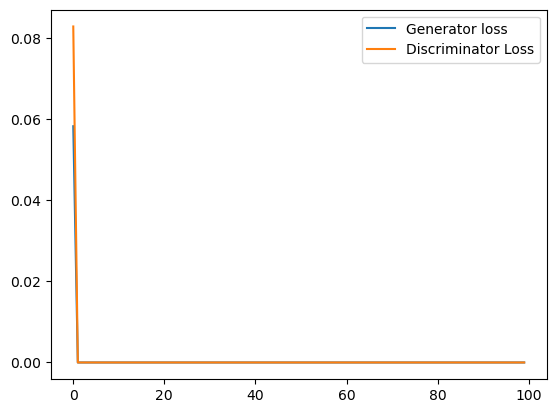

In [2]:
# plot and save the generator and discriminator loss
losses_g = [0.05826525166125552, 1.0874677564062839e-16, 1.2275054268809885e-16, 1.1772910823596771e-16, 9.402309441522743e-17, 9.983614402229425e-17, 1.0266569658027467e-16, 1.0034911322134684e-16, 1.168575141470711e-16, 1.0449393019449044e-16, 1.0691931264766705e-16, 1.1335145895261445e-16, 1.088792370069205e-16, 1.3983026648835577e-16, 1.1380793730106629e-16, 1.1363551537669563e-16, 1.060019695463035e-16, 1.1902355265651135e-16, 1.1397695186346615e-16, 1.0890438425905121e-16, 1.1233085709962628e-16, 1.138872365470808e-16, 9.590149083523921e-17, 1.192237601715309e-16, 1.0722995937934209e-16, 1.2783375817141393e-16, 1.14416322830125e-16, 1.1658166024390175e-16, 1.2101787319349197e-16, 1.1456130249329036e-16, 1.2142097516067778e-16, 8.49079796771964e-17, 1.1980019345272695e-16, 1.1448367758809423e-16, 1.1000976069983571e-16, 1.1416305377857632e-16, 1.652196451164884e-16, 1.0998253214816512e-16, 1.3459206017994926e-16, 1.0602407328281423e-16, 1.2812516437096451e-16, 1.2135634124719043e-16, 8.255469219351366e-17, 1.0436552703284287e-16, 1.1363801317934874e-16, 1.1553056502099452e-16, 1.1467993207059568e-16, 1.3634513453762693e-16, 1.5545170925834604e-16, 1.1780687339423217e-16, 1.1523102442627896e-16, 1.0870584713983477e-16, 8.85942635569669e-17, 1.3930886182867493e-16, 1.0582364850916027e-16, 3.250216571378359e-16, 8.952416519718702e-17, 2.594261667194307e-16, 1.0535309348384081e-16, 1.0731336029586785e-16, 1.0745009169574053e-16, 1.1332313157987406e-16, 1.3618832654519804e-16, 1.1693352750647624e-16, 9.559861063666391e-17, 1.2358608728439132e-16, 9.680934481755218e-17, 1.0851294969561522e-16, 1.14331003745388e-16, 1.4625460985011664e-16, 1.146641504118774e-16, 1.0962560061722363e-16, 1.3674047414296568e-16, 1.2841529514284958e-16, 1.4214223584796662e-16, 1.1984688918400983e-16, 1.3806221553786338e-16, 1.1556438912909396e-16, 1.147271074393753e-16, 9.404541405294795e-17, 9.713689336603313e-17, 8.979919848062936e-17, 1.113926323115233e-16, 1.358165268033118e-16, 9.652536815630579e-17, 8.572623083968731e-17, 1.7747541461668584e-16, 1.0199714389889655e-16, 1.2855986821492924e-16, 1.1169921096894579e-16, 1.1669518258186772e-16, 1.1821607879487178e-16, 1.4279764922485911e-16, 9.40417977041489e-17, 1.2069826894417334e-16, 1.2132961658284133e-16, 1.0298368618717742e-16, 1.005509270221371e-16, 1.171631929875254e-16, 1.1772363203165568e-16]
losses_d = [0.08286743800621559, 8.159039966540972e-11, 1.2736063744763325e-10, 3.5820263409231086e-11, 1.8109130047980285e-10, 1.1741070166409443e-10, 5.3730278838143286e-11, 7.164034362464319e-11, 8.557040643356222e-11, 4.378024311221049e-11, 2.1492104873855175e-10, 5.572029181399439e-11, 1.8507131523121562e-10, 1.5455758082424925e-10, 1.432807252790107e-10, 1.213905540869183e-10, 1.5323103022317657e-10, 1.4328077290970778e-10, 1.0348046445896063e-10, 1.293506302101293e-10, 6.169031538674211e-11, 8.557040621000835e-11, 8.75604008479391e-11, 7.960037911469916e-11, 2.527319670186984e-10, 2.1691154242818576e-10, 1.37310653460743e-10, 1.7114115267224548e-10, 1.213905931892075e-10, 5.970032006982918e-11, 1.233806805530903e-10, 1.6517082179497282e-10, 2.7263246158154815e-10, 1.293506686100806e-10, 1.5920095795327148e-10, 5.3730275815720706e-11, 3.582018920572476e-11, 4.4178511338757537e-10, 1.0149047198965191e-10, 1.7910089931289142e-10, 5.5720301550270485e-11, 9.353048213175694e-11, 4.0596541907071404e-10, 2.3283195078872055e-10, 1.3930068172004984e-10, 3.701443552388374e-10, 2.22881958157649e-10, 1.0945066692620091e-10, 9.353042716668084e-11, 2.288518359459318e-10, 8.955043024208138e-11, 2.089510856812709e-10, 1.293506569489249e-10, 1.6119100211377814e-10, 6.169029155959839e-11, 3.9800226189899713e-11, 9.353043503731819e-11, 5.572038755199547e-11, 1.1940058183606628e-10, 6.368030911113674e-11, 9.552047143175689e-11, 9.154053508298093e-11, 8.875625626901176e-10, 8.557041111865475e-11, 6.965052136382823e-11, 2.0298131155802162e-10, 9.353048680502707e-11, 6.169027474592492e-11, 8.159037954205408e-11, 1.1741060641947837e-10, 1.1741057667948605e-10, 9.55204828035469e-11, 1.393008089845761e-10, 1.293508506948976e-10, 7.761038558115541e-11, 7.164033248713312e-11, 7.164040382743651e-11, 7.960042739702906e-11, 7.363056264825276e-11, 6.76603199911972e-11, 1.1741057354783252e-10, 1.8507130964144588e-10, 9.950044300029588e-11, 6.368031656023686e-11, 5.7710296982758917e-11, 1.0746053319054655e-10, 1.4527099636145168e-10, 6.169029053873664e-11, 1.5721086076390708e-10, 3.1044250307337983e-10, 1.2935060038282793e-10, 8.756040197113405e-11, 8.159042421763212e-11, 1.2736065865533724e-10, 3.582039228990115e-11, 1.014905268315868e-10, 4.9750312784896654e-11, 1.5721080066162537e-10, 9.751043611605106e-11, 1.5124078544243373e-10]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss_b.png')

# Q1.c

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 64
epochs = 100
sample_size = 64  # fixed sample size for the generator
nz = 128  # latent vector size
k = 10  # number of steps to apply to the discriminator
lr_g = 0.0002  # learning rate for the generator
lr_d = 0.0002  # learning rate for the discriminator
clip_value = 0.01  # clip parameter for weight clipping (optional)


# # learning parameters
# batch_size = 512
# epochs = 100
# sample_size = 64 # fixed sample size for generator
# nz = 128 # latent vector size
# k = 1 # number of steps to apply to the discriminator
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Selected device:', device)


transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            # Remove Sigmoid activation
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)



# optimizers
# optim_g = optim.Adam(generator.parameters(), lr=0.0002)
# optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

optim_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.9, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.9, 0.999))

# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)



torch.manual_seed(7777)
torch.cuda.manual_seed(7777)

def wasserstein_loss(output, target):
    return -torch.mean(output * target)

def generator_loss(output):
    return -torch.mean(output)

def discriminator_loss(real_output, fake_output):
    return wasserstein_loss(real_output, label_real(real_output.size(0))) + wasserstein_loss(fake_output, label_fake(fake_output.size(0)))
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        # Training Discriminator
        for _ in range(k):
            optim_d.zero_grad()

            # Real data
            real_data = data[0].to(device)
            real_output = discriminator(real_data)
            loss_real = criterion(real_output, label_real(real_data.size(0)))

            # Fake data
            fake_data = generator(create_noise(batch_size, nz)).detach()
            fake_output = discriminator(fake_data)
            loss_fake = criterion(fake_output, label_fake(fake_data.size(0)))

            # Update the discriminator
            loss_d += loss_real.item() + loss_fake.item()
            (loss_real + loss_fake).backward()
            optim_d.step()
    
            # Optional: Clip discriminator weights
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        # Training Generator
        optim_g.zero_grad()
        generated_data = generator(create_noise(batch_size, nz))
        output = discriminator(generated_data)
        loss_fake_g = criterion(output, label_real(batch_size))
        loss_g += loss_fake_g.item()
        
        # Update the generator
        loss_fake_g.backward()
        optim_g.step()
    
        # Optional: Clip discriminator weights after generator update
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}c.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi  # total generator loss for the epoch
    epoch_loss_d = loss_d / (bi*k)  # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
print(losses_g)
print(losses_d)

In [ ]:
# plot and save the generator and discriminator loss
losses_g = [2.3789363197481364, 1.091393338641591, 0.9570870810410002, 1.0558285057989993, 0.9831985046922079, 0.9277771888191443, 0.7642152004715218, 0.705388270739939, 0.6980525414869905, 0.7192841062805314, 0.8877784687401518, 1.2858006315526485, 0.8795848343135707, 0.7250082354789864, 0.6961121966261238, 0.7600496906862697, 0.7725225698477176, 0.7527223618078893, 0.7316180539487392, 0.7268471116699048, 0.713109076659224, 0.704453204141228, 0.7008571529973661, 0.6961602013927896, 0.7007669438801809, 0.9528182473991825, 1.141921901270318, 1.1062499616163899, 0.8887490517556222, 0.7103196536464141, 0.696378868761032, 0.6985435085082894, 0.6998195052783034, 0.7014103618350075, 0.7843063026507611, 0.9816447867273393, 0.7797194514483246, 0.7240838417375863, 0.7387037995403579, 0.7961326918963307, 0.843989894446085, 0.7619194206458655, 0.7317402802383887, 0.7734898354226014, 0.9121305900551339, 0.8245185766301516, 0.7493501441710277, 0.7383078344985287, 0.7198134331209555, 0.7294857149571975, 0.7165989604805424, 0.7412752280113155, 1.009109564308423, 0.940688261736419, 0.7711779100536155, 0.7184181932833049, 0.7295782313530066, 0.7592090719410297, 0.6987428291121313, 0.6964246132585002, 0.6879422596577265, 0.6939762543843166, 0.6977913183107447, 0.7033582843736752, 0.7060072602050155, 0.7073536095713348, 0.6969578642091985, 0.6971586923589065, 0.7091491939291247, 0.8391064327834383, 0.8135456276168945, 0.740085088328847, 0.732919366408056, 0.732647659111939, 0.7378353822574799, 0.7618638738878508, 0.7767384459394783, 0.7465502946710129, 0.7445241067809, 0.7744395161641955, 0.7682698820036783, 0.7647152561515475, 0.7404377366333659, 0.7430630007573864, 0.7530975330346676, 0.7643390739994599, 0.7862323550557123, 0.7461623908234253, 0.7423809954425441, 0.7565673921126057, 0.7731586778049407, 0.7403253958090392, 0.7336337157349194, 0.7497298322466929, 0.739019054168062, 0.7638373663738418, 0.8956093129760555, 0.9889431677225942, 0.9681884262834058, 0.9078544149912791]
losses_d = [0.5705519847824124, 1.0828262826867139, 1.1733121778692737, 1.14743940238001, 1.2030843926881905, 1.24316453866923, 1.3422564121581446, 1.383511454108685, 1.3866940876335827, 1.3757479699183426, 1.3265595909879964, 1.1937446479799907, 1.3377464142782074, 1.3796312356675828, 1.3870313493775457, 1.3195494932419718, 1.290902740914641, 1.3086983908297793, 1.3329008045802122, 1.343298057402338, 1.3584549954250502, 1.3695368898652789, 1.3755894206376824, 1.3803602251833507, 1.3826555231464839, 1.2228848199993212, 1.09719224881019, 1.1306289076836922, 1.2685482387545268, 1.381803077675617, 1.387094149779103, 1.3867949722670694, 1.3817849040603942, 1.382910640981434, 1.3634997318368585, 1.3081733371462105, 1.3661647372591839, 1.379424471674505, 1.3756929605531336, 1.359589482683255, 1.3499963578604075, 1.3705468415100774, 1.3775909908712227, 1.3631704505791404, 1.3328100413465704, 1.3553485473707365, 1.3728318210822414, 1.374921415553785, 1.373738707330082, 1.3649147376465822, 1.373656927788652, 1.3739514704225158, 1.2957998090645293, 1.3205779622655796, 1.3668640870072162, 1.3809256422990415, 1.3771482411990679, 1.3705808851800325, 1.3538946058032606, 1.3338503445479761, 1.3176227672377416, 1.3037209417611328, 1.2872241607597823, 1.2775407667602776, 1.2810489664210072, 1.309630904120086, 1.3560191036447518, 1.3852827978617608, 1.3838372303429383, 1.3491982163907115, 1.3552990707669212, 1.374858639751071, 1.3762106496184714, 1.3778992571851105, 1.375977134319736, 1.3658272349338267, 1.3641184587520623, 1.373365843451901, 1.3744690513884372, 1.3677204199922504, 1.3675100642913434, 1.3689708083390935, 1.3747876215547228, 1.373612123412918, 1.3718879963856752, 1.3682446181328853, 1.3639677215443096, 1.3733586382013503, 1.3736570903178595, 1.3703708334818976, 1.3662910589318138, 1.3748975982819958, 1.3759595115258574, 1.3728624222722607, 1.3752061114526228, 1.3667501612941126, 1.3320336350381947, 1.3006340400768064, 1.3024769855060851, 1.3286586649739756]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

# Q3

# Q3.4

In [1]:
# Original
from graphviz import Graph

# Mutual information values
mutual_info_values = {
    ('X', 'Y'): 0.2780,
    ('X', 'Z'): 0.1328,
    ('Z', 'Y'): 0.3973
}

# Create a directed graph
graph = Graph('MutualInformationGraph', format='png')

# Add nodes
graph.node('Y')
graph.node('X')
graph.node('Z')

# Add edges with labels (mutual information values)
for (node1, node2), mi_value in mutual_info_values.items():
    graph.edge(node1, node2, label=f'{mi_value:.4f}')

# Save the graph to a file (e.g., MutualInformationGraph.png)
graph.render(filename='q3_a', cleanup=True, format='png', directory='./')



'q3_a.png'

In [2]:
import graphviz

# Create a Graph (undirected graph)
graph = graphviz.Graph('SimpleTree', format='png')

# Add nodes
graph.node('X', 'X')
graph.node('Y', 'Y')
graph.node('Z', 'Z')

# Add edges with values
graph.edge('X', 'Y', label=' 0.2780')
graph.edge('Y', 'Z', label=' 0.3973')

# Save the graph to a file (e.g., SimpleTree.png)
graph.render('q3b', view=True)



'q3b.png'

# Q3.5

In [3]:
import graphviz

# Create a Digraph (directed graph)
dot = graphviz.Digraph('SimpleTree', format='png')

# Add nodes
dot.node('X', 'X')
dot.node('Y', 'Y')
dot.node('Z', 'Z')

# Add edges with values
dot.edge('X', 'Y', label=' 0.2780')
dot.edge('Y', 'Z', label=' 0.3973')

# Save the graph to a file (e.g., SimpleTree.png)
dot.render('q3c', view=True)


'q3c.png'